In [1]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_data_template
from src.features.games import GameFeatures

In [2]:
game_feat = GameFeatures(default_lags=3)
data = load_data_template()
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_season, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_season_against_opponent, fillna=0, per_game=True)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney_against_opponent, fillna=0, per_game=True)
data = game_feat.per_team_wrapper(data, game_feat.average_ranking_team, fillna=0, per_game=False)
data = game_feat.per_team_wrapper(data, game_feat.sd_ranking_team, fillna=0, per_game=False)

data.sample()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum,games_won_in_season_team_a,games_won_in_season_team_a_lag-1,games_won_in_season_team_a_lag-2,...,average_ranking_team_b_lag-2,average_ranking_team_b_lag-3,sd_rankings_team_a,sd_rankings_team_a_lag-1,sd_rankings_team_a_lag-2,sd_rankings_team_a_lag-3,sd_rankings_team_b,sd_rankings_team_b_lag-1,sd_rankings_team_b_lag-2,sd_rankings_team_b_lag-3
5414,2016,1192,1246,True,0,NaN,0.0,17,7.0,9.0,...,20.905134,37.146429,27.459898,39.173769,29.091764,51.341102,9.309696,1.302351,10.808901,19.63174


In [3]:
data = data.dropna()
data.sample()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum,games_won_in_season_team_a,games_won_in_season_team_a_lag-1,games_won_in_season_team_a_lag-2,...,average_ranking_team_b_lag-2,average_ranking_team_b_lag-3,sd_rankings_team_a,sd_rankings_team_a_lag-1,sd_rankings_team_a_lag-2,sd_rankings_team_a_lag-3,sd_rankings_team_b,sd_rankings_team_b_lag-1,sd_rankings_team_b_lag-2,sd_rankings_team_b_lag-3
10550,2007,1397,1438,False,0,True,139.0,22,21.0,14.0,...,52.532438,61.285714,13.469452,14.728367,28.592437,22.018989,26.977775,32.591489,30.786014,26.960756


In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target', 'DayNum'], axis=1)
y = data[['a_win']].astype(int)

kf = KFold(n_splits=15, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i]
    X_t, y_t = X.iloc[t_i], y.iloc[t_i]
    xgb = XGBClassifier()
    xgb.fit(X_tr.values, y_tr.values.reshape(-1))
    preds = xgb.predict_proba(X_t.values)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.369062233434
0.393418030961
0.41238594721
0.393363331375
0.375244395624
0.348946456546
0.391202485839
0.368210397842
0.387125595559
0.386102104381
0.395628096955
0.337632817315
0.391751099705
0.331504700973
0.339612772779
Metric Mean: 0.37 (0.02)


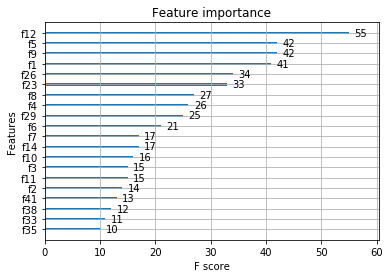

In [17]:
from xgboost import plot_importance

plt.figure(figsize=(20,8))
plot_importance(xgb, max_num_features=20)
plt.show()

In [10]:
X.columns.to_series().reset_index()

,index,0
0,game_set,game_set
1,games_won_in_season_team_a,games_won_in_season_team_a
2,games_won_in_season_team_a_lag-1,games_won_in_season_team_a_lag-1
3,games_won_in_season_team_a_lag-2,games_won_in_season_team_a_lag-2
4,games_won_in_season_team_a_lag-3,games_won_in_season_team_a_lag-3
5,games_won_in_season_team_b,games_won_in_season_team_b
6,games_won_in_season_team_b_lag-1,games_won_in_season_team_b_lag-1
7,games_won_in_season_team_b_lag-2,games_won_in_season_team_b_lag-2
8,games_won_in_season_team_b_lag-3,games_won_in_season_team_b_lag-3
9,games_won_in_tourney_team_a_lag-1,games_won_in_tourney_team_a_lag-1
